In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xgboost as xgb

In [6]:
rng = np.random.RandomState(1991)

## 借助sklearn中cv保存各个模型

In [7]:
from sklearn.datasets import load_digits

In [8]:
from sklearn.cross_validation import KFold

In [9]:
digits = load_digits(2)

In [10]:
X = digits['data']
y = digits['target']

In [11]:
kf = KFold(y.shape[0], n_folds=2, shuffle=True, random_state=rng)

In [16]:
xgb_models = []
for train_index, test_index in kf:
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index]) #二分类
    xgb_models.append(xgb_model)
    preds = xgb_model.predict(X[test_index])
    labels = y[test_index]
    err = sum(1 for i in range(len(preds))
              if int(preds[i]>0.5) != labels[i]) / float(len(preds))
    

In [17]:
len(xgb_models)

2

## 多分类

In [18]:
from sklearn.datasets import load_iris
from sklearn.cross_validation import KFold

In [27]:
def check_pred(preds, labels):
    err = sum(1 for i in range(len(preds))
              if int(preds[i] > 0.5) != labels[i]) / float(len(preds))
#     assert err < 0.1

In [28]:
iris = load_iris()

In [29]:
X = iris['data']
y = iris['target']

In [30]:
kf = KFold(y.shape[0], n_folds=2, shuffle=True, random_state=rng)

In [31]:
y.shape

(150,)

In [32]:
for train_index, test_index in kf:
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    preds = xgb_model.predict(X[test_index])
    # 测试几个predict()中的参数
    preds2 = xgb_model.predict(X[test_index], output_margin=True, ntree_limit=3)
    preds3 = xgb_model.predict(X[test_index], output_margin=True, ntree_limit=0)
    preds4 = xgb_model.predict(X[test_index], output_margin=False, ntree_limit=3)
    labels = y[test_index]
    
    check_pred(preds, labels)
    check_pred(preds2, labels)
    check_pred(preds3, labels)
    check_pred(preds4, labels)
    

## 回归问题

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.cross_validation import KFold

In [40]:
boston = load_boston()

In [41]:
X = boston['data']

In [42]:
y = boston['target']

In [43]:
kf = KFold(y.shape[0], n_folds=2, shuffle=True, random_state=rng)

In [44]:
for train_index, test_index in kf:
    xgb_model = xgb.XGBRegressor().fit(X[train_index], y[train_index])
    preds = xgb_model.predict(X[test_index])
    

## 使用 sklearn中网格搜索调参

In [46]:
from sklearn.grid_search import GridSearchCV

In [48]:
xgb_model = xgb.XGBRegressor()

In [49]:
clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                               'n_estimators': [50, 100, 200]}, verbose=1)

In [50]:
clf.fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    3.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [2, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [51]:
clf.best_score_

0.59848792071667345

In [52]:
clf.best_params_

{'max_depth': 4, 'n_estimators': 100}

## 自定义损失函数, XGBClassifier和XGBRegressor都支持

In [63]:
def objective_ls(y_true, y_pred):
    grad = y_pred - y_true
    hess = np.ones(len(y_true))
    return grad, hess

In [64]:
kf = KFold(y.shape[0], n_folds=2, shuffle=True, random_state=rng )

In [65]:
for train_index, test_index in kf:
    xgb_model = xgb.XGBRegressor(objective=objective_ls).fit(X[train_index], y[train_index])
    preds = xgb_model.predict(X[test_index])
    labels = y[test_index]

## 可视化

In [66]:
iris = load_iris()

In [78]:
classifier = xgb.XGBClassifier()

In [79]:
classifier.fit(iris['data'], iris['target'])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [80]:
import matplotlib

In [81]:
matplotlib.use('Agg')

In [82]:
from matplotlib.axes import Axes
from graphviz import Digraph

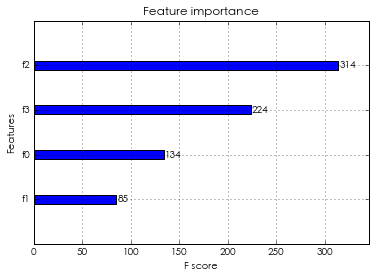

In [83]:
ax = xgb.plot_importance(classifier)

In [84]:
g = xgb.to_graphviz(classifier, num_trees=4)

## 交叉验证 StratifiedKFold 和xgb.cv()

In [107]:
from sklearn.cross_validation import StratifiedKFold

In [108]:
X = load_digits(2)['data']
y = load_digits(2)['target']
dm = xgb.DMatrix(X, label=y)

In [109]:
params = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'multi:softmax', 'num_class': 3}

In [110]:
seed = 1987

In [111]:
nfolds = 5

In [112]:
skf = StratifiedKFold(y, n_folds=nfolds, shuffle=True, random_state=seed)

In [113]:
cv1 = xgb.cv(params, dm, num_boost_round=10, nfold=nfolds, seed=seed)

In [114]:
cv2 = xgb.cv(params, dm, num_boost_round=10, nfold=nfolds, seed=seed, stratified=True)